# GoogleNet

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs) -> None:
        super().__init__()
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # torch.cat((p1, p2, p3, p4), dim=1) 是在dim=1（通道维度）拼接各个分支的输出，常用于通道上拼接不同特征图（如Inception结构所需）
        # torch.stack((p1, p2, p3, p4), dim=1) 则是新建一个维度，将4个tensor在该新维度堆叠，结果shape比cat多1个维度（通常不是特征融合需要）
        # 因此，这里应该继续使用cat而不是stack
        return torch.cat((p1, p2, p3, p4), dim=1)

In [3]:
# cat和stack区别示例

a = torch.randn(2, 3)
b = torch.randn(2, 3)
print("a shape:", a.shape, a)
print("b shape:", b.shape, b)

# 用cat拼接（比如dim=0，行拼接，结果是4x3）
cat_ab = torch.cat((a, b), dim=0)
print("cat (dim=0) shape:", cat_ab.shape, cat_ab)

# 用cat拼接（比如dim=1，列拼接，结果是2x6）
cat_ab_col = torch.cat((a, b), dim=1)
print("cat (dim=1) shape:", cat_ab_col.shape, cat_ab_col)

# 用stack堆叠（比如dim=0，新加一维，结果是2x2x3）
stack_ab = torch.stack((a, b), dim=0)
print("stack (dim=0) shape:", stack_ab.shape)
print(stack_ab)
print("stack (dim=0)[0] == a:", torch.equal(stack_ab[0], a))
print("stack (dim=0)[1] == b:", torch.equal(stack_ab[1], b))

# 用stack堆叠（比如dim=1，新加一维，结果是2x2x3）
stack_ab_dim1 = torch.stack((a, b), dim=1)
print("stack (dim=1) shape:", stack_ab_dim1.shape)
print(stack_ab_dim1)
print("stack (dim=1)[0][0] == a[0]:", torch.equal(stack_ab_dim1[0][0], a[0]))
print("stack (dim=1)[0][1] == b[0]:", torch.equal(stack_ab_dim1[0][1], b[0]))
print("\n解释：")
print("stack(dim=0)会在最前面增加一个新维度（选a还是b），其后分别是a、b本身。")
print("stack(dim=1)会在原来的第1维（通常是行）上增加新维度，二维看，每一行纵向堆叠a、b对应行。")
print("举例：stack(dim=0)[0]拿到的是a整体，stack(dim=1)[0][0]拿到的是a的第0行；stack(dim=1)[0][1]是b的第0行。")


a shape: torch.Size([2, 3]) tensor([[-1.1980, -0.2807,  0.8085],
        [ 0.9135, -1.5916, -0.4776]])
b shape: torch.Size([2, 3]) tensor([[-0.1326, -0.2887,  0.3942],
        [ 0.7980, -1.6782, -0.9196]])
cat (dim=0) shape: torch.Size([4, 3]) tensor([[-1.1980, -0.2807,  0.8085],
        [ 0.9135, -1.5916, -0.4776],
        [-0.1326, -0.2887,  0.3942],
        [ 0.7980, -1.6782, -0.9196]])
cat (dim=1) shape: torch.Size([2, 6]) tensor([[-1.1980, -0.2807,  0.8085, -0.1326, -0.2887,  0.3942],
        [ 0.9135, -1.5916, -0.4776,  0.7980, -1.6782, -0.9196]])
stack (dim=0) shape: torch.Size([2, 2, 3])
tensor([[[-1.1980, -0.2807,  0.8085],
         [ 0.9135, -1.5916, -0.4776]],

        [[-0.1326, -0.2887,  0.3942],
         [ 0.7980, -1.6782, -0.9196]]])
stack (dim=0)[0] == a: True
stack (dim=0)[1] == b: True
stack (dim=1) shape: torch.Size([2, 2, 3])
tensor([[[-1.1980, -0.2807,  0.8085],
         [-0.1326, -0.2887,  0.3942]],

        [[ 0.9135, -1.5916, -0.4776],
         [ 0.7980, -1.6782

In [4]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [5]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [6]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [9]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [10]:
X = torch.rand((1,1,96,96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, X.shape)

Sequential torch.Size([1, 64, 24, 24])
Sequential torch.Size([1, 192, 12, 12])
Sequential torch.Size([1, 480, 6, 6])
Sequential torch.Size([1, 832, 3, 3])
Sequential torch.Size([1, 1024])
Linear torch.Size([1, 10])


training on cpu


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x111aedcf0>
Traceback (most recent call last):
  File "/Users/haoyiwen/miniforge3/envs/d2l/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    def __del__(self):
  File "/Users/haoyiwen/miniforge3/envs/d2l/lib/python3.10/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 15713) is killed by signal: Abort trap: 6. 


KeyboardInterrupt: 

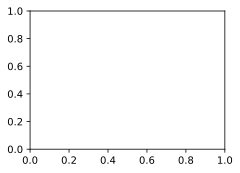

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())